In [ ]:
!git clone https://github.com/WegraLee/deep-learning-from-scratch.git
%cd '/content/deep-learning-from-scratch'

Cloning into 'deep-learning-from-scratch'...
remote: Enumerating objects: 830, done.
remote: Total 830 (delta 0), reused 0 (delta 0), pack-reused 830
Receiving objects: 100% (830/830), 52.21 MiB | 21.38 MiB/s, done.
Resolving deltas: 100% (477/477), done.
/content/deep-learning-from-scratch


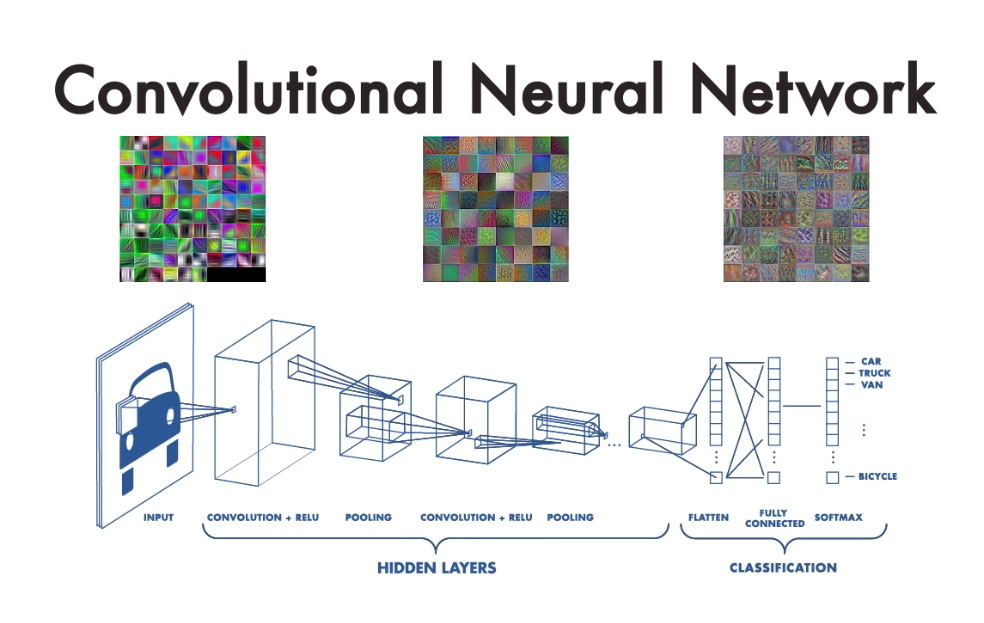

**CNN** : application to fields such as image recognition and voice recognition
- **convolutional layer** : extraction of spatial patterns from the shape of multidimensional data
 - input feature map : input data of convolution layer
 - output feature map : output data of convolution layer
    - shape of data in CNN : (batch size, number of channels, height, width)
 - convolution filter (kernel) operation : fused multiply add (FMA) with window shift
    - cross correlation : convolution without kernel flipping (no clear distinction needed) 
    - not fully connected (affine layer : fully connected layer of a typical neural network)
 - padding : filling the area around the input data with a specific value
 - stride : step size of window shift
 - formula for the size of output : (OH, OW) (input : (H, W) / filter : (FH, FW) / padding : P / stride : S)
    - OH = (H + 2P - FH) / S + 1
    - OW = (W + 2P - FW) / S + 1
    - C : number of channels of input ; number of channels of filter
    - FN : number of filters to use ; number of channels of output
     - bias given per filter
    - shape of weights in a convolutional layer : (FN, C, FH, FW)

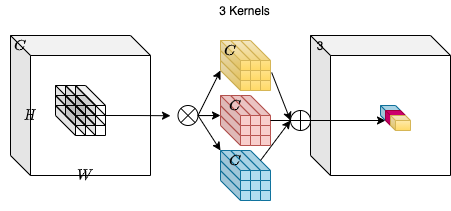

- **pooling layer** : aggregation (summary) conducted after each convolutional layer
 - max pooling (image recognition) / average pooling
 - (size) stride = window
    - stride < window : overlapping
 - no parameter to learn
 - no change in number of channels (operated independently for each channel)

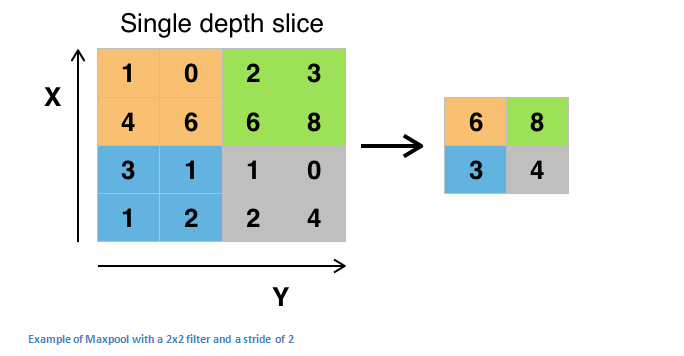

< 합성곱 연산 프로세스 >
1. **im2col** : 합성곱 필터 연산에 용이하도록 입력 데이터를 변형 ; 4차원 미니배치 $\rightarrow$ 2차원 행렬
 - 필터의 윈도우 적용 영역을 한 줄로 평탄화 $\rightarrow$ 스트라이드에 따른 윈도우 영역 간 중첩 부분을 저장하기 위한 추가 메모리 필요
2. im2col의 출력과 평탄화된 합성곱 필터의 행렬곱(내적)을 통해 합성곱 필터 연산 구현 ; 어파인 연산으로 단순화
3. CNN 데이터의 형태로 변환 ; 2차원 행렬 $\rightarrow$ 4차원 미니배치

✔︎ 합성곱 역전파 : Affine 계층의 역전파 계산 + **col2im** (im2col의 역 과정)

In [ ]:
import numpy as np
from common.util import im2col
x = np.random.rand(10,3,7,7) # batch size, number of channels, height, width
col = im2col(input_data=x, filter_h=5, filter_w=5, stride=1, pad=0)
print(col.shape)
# OH, OW를 계산해보면 3, 3이므로 데이터 샘플(이미지) 1개당 im2col을 적용하면 9(=3*3)행을 반환
# batch size가 10이므로 총 90행
# 윈도우 영역 1개당 원소가 75(=3*5*5)개이므로 총 75열
# 행렬의 세로 방향으로 윈도우 간 순회 / 가로 방향으로 윈도우 내 순회
# 즉, 여기서는 9행 75열이 데이터 샘플 1개를 변형한 2차원 행렬
# 미니배치 전체를 변형하면 각 2차원 행렬을 세로로 쌓은 2차원 행렬

(90, 75)


In [ ]:
# Convolution 계층
from common.util import im2col, col2im # 역전파에서 im2col의 역 과정 필요
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

        self.x = None   
        self.col = None
        self.col_W = None
        
        self.dW = None
        self.db = None
    
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        # 합성곱 필터 평탄화
        col_W = self.W.reshape(FN, -1).T # 세로 방향으로 필터 내 매개변수 순회 / 가로 방향으로 필터 간 순회
        out = np.dot(col, col_W) + self.b # 어파인 연산

        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2) # (N, FN, out_h, out_w)

        # 역전파 대비
        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

In [ ]:
# Pooling 계층
# im2col을 사용하되, 채널별로 독립적인 수행이므로 shape 주의
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride) # H // self.pool_h
        out_w = int(1 + (W - self.pool_w) / self.stride) # W // self.pool_w
        
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        # 채널별 독립적인 수행에 적합하게 변형
        col = col.reshape(-1, self.pool_h*self.pool_w) # 열 내에서 채널이 바뀌면 개행
        # 채널 내 최댓값 탐색
        arg_max = np.argmax(col, axis=1) # 최댓값 위치
        out = np.max(col, axis=1) # 최댓값

        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        # 역전파 대비
        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

CNN 구현 - MNIST 분류
>SimpleConvNet : [Conv$\rightarrow$ReLU$\rightarrow$Pooling] $\longrightarrow$ [Affine$\rightarrow$ReLU] $\longrightarrow$ [Affine$\rightarrow$Softmax] 

In [ ]:
# CNN 구현
import pickle
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient

class SimpleConvNet:
    """
    Parameters
    ----------
    input_size : 입력 크기
    hidden_size_list : 각 은닉층의 뉴런 개수를 담은 리스트
    output_size : 출력 크기
    activation : 활성화 함수 - 'relu' | 'sigmoid'
    weight_init_std : 가중치 초기화의 표준편차 지정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
            # 입력과 필터 모두 정방형이므로 width와 height를 동일한 size로 표시
            # Pooling filter : 2*2 (stride=2)

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t): # t : 정답 레이블
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim!=1:
            t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y==tt) 
        
        return acc / x.shape[0]

    # def numerical_gradient(self, x, t):
    #     loss_w = lambda w: self.loss(x, t)
    #     grads = {}
    #     for idx in (1, 2, 3):
    #         grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
    #         grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])
    #     return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

train loss:2.2986472559135533
=== epoch:1, train acc:0.258, test acc:0.312 ===
train loss:2.2955604048325484
train loss:2.2915707887545493
train loss:2.286781113714482
train loss:2.2805412833235055
train loss:2.2727627419640113
train loss:2.259812107459901
train loss:2.2591956360137706
train loss:2.235511919082818
train loss:2.204061920744702
train loss:2.2022078382191994
train loss:2.1888180503098917
train loss:2.16090255495608
train loss:2.1341170175702198
train loss:2.102879130909359
train loss:2.1124788702188435
train loss:2.0671048776743515
train loss:1.9983843478172902
train loss:1.951769892793449
train loss:1.9795640069548983
train loss:1.8910130212694027
train loss:1.8127654483844446
train loss:1.7392684071508984
train loss:1.6831635345739844
train loss:1.5626707142927345
train loss:1.65549566646269
train loss:1.5151863297750732
train loss:1.5153691118138468
train loss:1.3866183997470107
train loss:1.2978170681657832
train loss:1.2906713951786442
train loss:1.2452684907822769
t

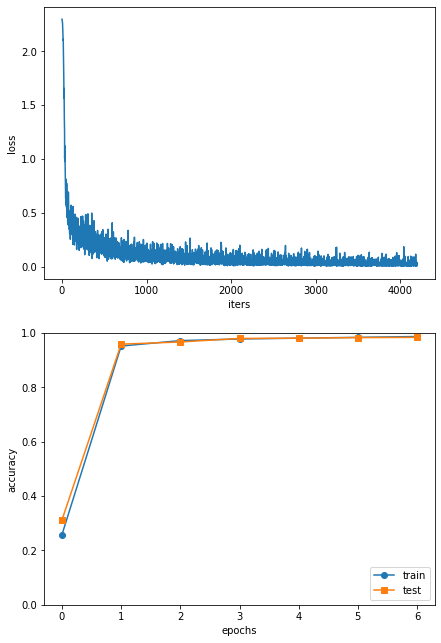

In [ ]:
# 학습 예제 구현
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from ch07.simple_convnet import SimpleConvNet
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

max_epochs = 7

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 20, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=50, output_size=10, weight_init_std=0.02)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
x = np.arange(max_epochs)
fig, axes = plt.subplots(2,1,figsize=(7,11))
axes[0].plot(trainer.train_loss_list, label='loss', markevery=50)
axes[0].set_xlabel('iters')
axes[0].set_ylabel('loss')

axes[1].plot(x, trainer.train_acc_list, marker='o', label='train')
axes[1].plot(x, trainer.test_acc_list, marker='s', label='test')
axes[1].set_xlabel("epochs")
axes[1].set_ylabel("accuracy")
axes[1].set_ylim(0, 1.0)
axes[1].legend(loc='lower right')

plt.show()

**※ 합성곱 필터 시각화**
>학습된 필터의 매개변수는 입력된 이미지에서 일종의 규칙성(edge, blob, texture, ...)을 검사
- 층이 깊어짐 $\rightarrow$ 복잡하고 추상화된 규칙성을 검사 $\rightarrow$ 데이터(이미지)에 잠재된 고급 정보 이해

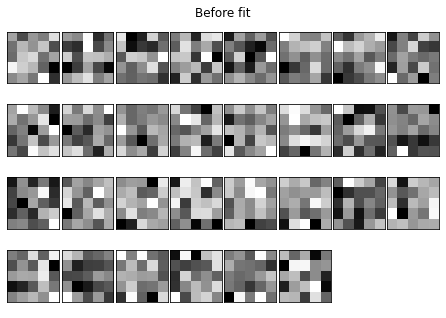

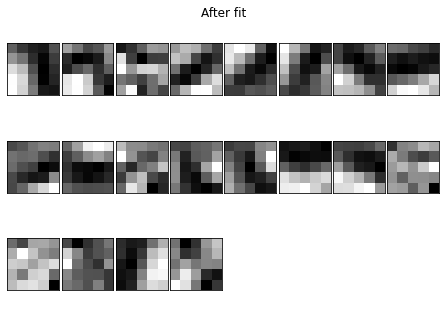

In [ ]:
from ch07.simple_convnet import SimpleConvNet

# 필터의 매개변수를 픽셀 값으로 시각화하는 함수 정의
def filter_show(filters, nx=8, margin=3, scale=10, fit=True):
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))
    fig = plt.figure()
    plt.title(['Before fit','After fit'][fit])
    plt.axis('off')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

# 학습 전 필터 매개변수
network = SimpleConvNet()
filter_show(network.params['W1'], fit=False)

# 학습 후 필터 매개변수 ; 예제 코드의 학습 과정에서 저장한 필터 매개변수 불러오기
network.load_params("params.pkl")
filter_show(network.params['W1'])

[< CNN 계열의 신경망 예시 >](https://yeong-jin-data-blog.tistory.com/entry/%EC%82%AC%EC%A0%84%ED%95%99%EC%8A%B5-%EB%AA%A8%EB%8D%B8-CNN)

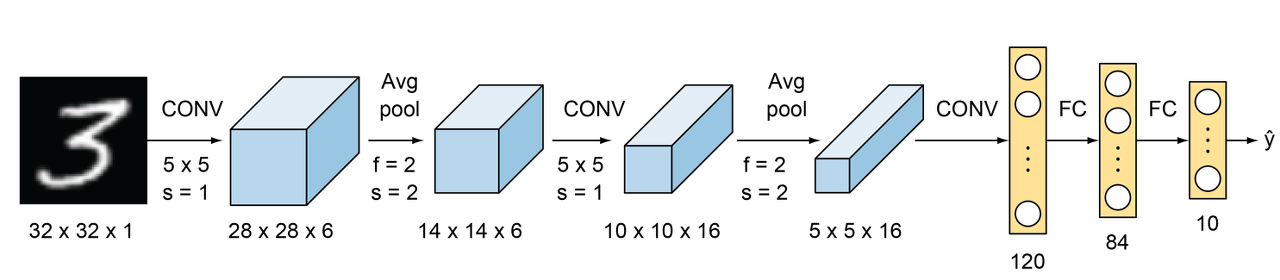

1. **LeNet** (1998) : CNN의 prototype
 - sigmoid / Subsampling (Pooling)

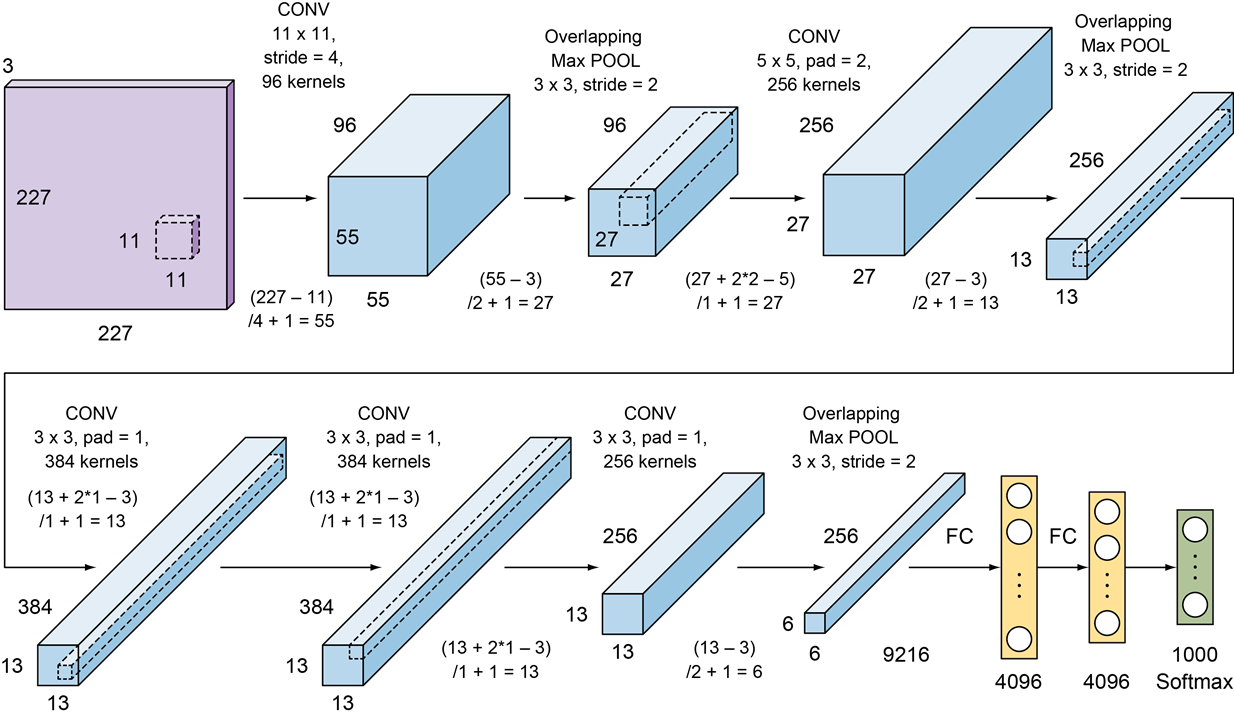

2. **AlexNet** (2012) : CNN의 성공적인 적용 사례 ; [*참고 링크*](https://bskyvision.com/entry/CNN-%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98%EB%93%A4-AlexNet%EC%9D%98-%EA%B5%AC%EC%A1%B0)
 - ReLU / Dropout / Overlapping Max Pooling / Local Response Normalization (LRN) / Data Augmentation
>LRN : 비교적 크게 활성화된 뉴런의 주변에 대한 normalization  
>
>Data Augmentation

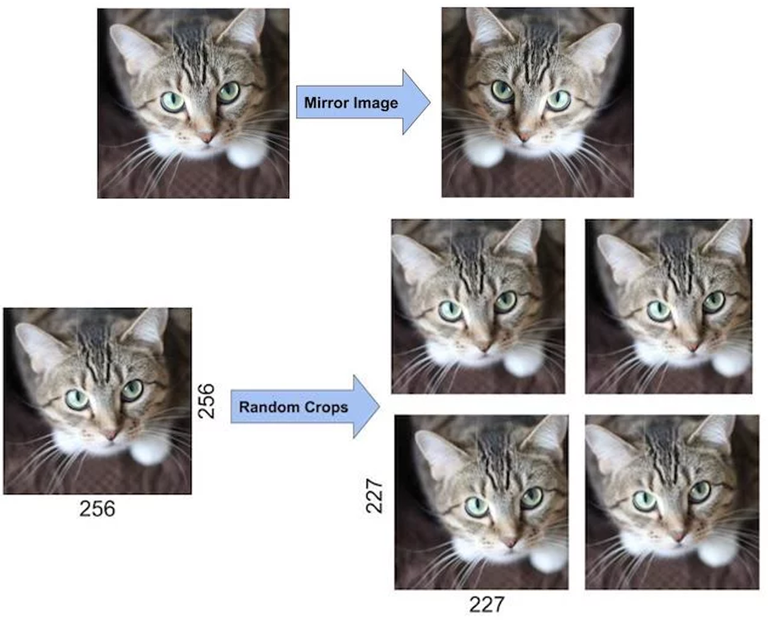

- **VGGNet / InceptionNet (GoogleNet) / ResNet / MobileNet / DenseNet / EfficientNet**